# Mapping 'sit-lie' arrests by LAPD: 2010-19

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import matplotlib.pyplot as pylt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
plt.rcParams["figure.figsize"] = [20,25]

### Read in arrests data from city portal

In [2]:
# https://data.lacity.org/api/views/yru6-6re4/rows.csv?accessType=DOWNLOAD
arrests = pd.read_csv('/Users/mhustiles/data/data/LA/Arrest_Data_from_2010_to_Present.csv')

### Clean up arrests DataFrame

In [3]:
arrests.columns = arrests.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
arrests['arrest_date'] = pd.to_datetime(arrests['arrest_date'], format='%m/%d/%Y')
arrests['year'] = arrests['arrest_date'].dt.year
arrests['day'] = arrests['arrest_date'].dt.day
arrests['month'] = arrests['arrest_date'].dt.month
arrests['monthname'] = arrests['arrest_date'].dt.month_name()
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month', 'day']] = \
arrests[['report_id', 'time', 'area_id', 'charge_group_code', 'reporting_district', 'year', 'month','day']].astype(str)
arrests['charge_group_code'] = arrests['charge_group_code'].str.replace('.0', '', regex=False)
arrests['weekday'] = arrests['arrest_date'].dt.weekday_name
arrests['time'] = arrests['time'].str.replace('.0','', regex=False)
arrests['time'] = arrests['time'].str.zfill(4)
arrests['hour'] = arrests['time'].str[:2]
arrests['minute'] = arrests['time'].str[2:]
arrests = arrests[arrests['hour'] != '0n']
arrests = arrests[arrests['hour'] != '24']

# Highlight nighttime hours
night = ['01', '02', '03', '04', '05', '22', '23', '00']
arrests['night'] = arrests['hour'].isin(night)
night_arrests = arrests[arrests['hour'].isin(night)]

# Separate location field into lat/lon
arrests['location'] = arrests.location.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in arrests['location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

arrests['latitude'] = lat
arrests['longitude'] = lon
arrests['latitude'] = arrests['latitude'].astype(float)
arrests['longitude'] = arrests['longitude'].astype(float)

In [4]:
mile = gpd.read_file('input/mile.geojson')
halfmile = gpd.read_file('input/halfmile.geojson')
halfmileshp = gpd.read_file('input/shp/halfmile.shp')
mile_gdf = gpd.GeoDataFrame(mile, geometry='geometry')
halfmile_gdf = gpd.GeoDataFrame(halfmile, geometry='geometry')

In [5]:
halfmileshp['geometry'] = halfmileshp['geometry'].to_crs(epsg=4326)
mile['geometry'] = mile['geometry'].to_crs(epsg=4326)

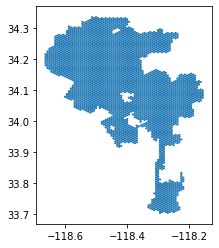

In [6]:
halfmileshp.plot()

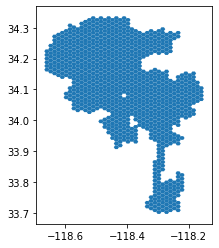

In [7]:
mile_gdf.plot()

### Isolate sit-lie cases from larger arrests dataframe

In [8]:
sit_lie_all = arrests[arrests.charge.str.contains('41.18')]

### Convert the sit-lie cases to a geodataframe

In [9]:
sit_lie_all_gdf = gpd.GeoDataFrame(sit_lie_all, \
geometry=gpd.points_from_xy(sit_lie_all.longitude, sit_lie_all.latitude))

### Remove stray LA arrests with the clip_data module

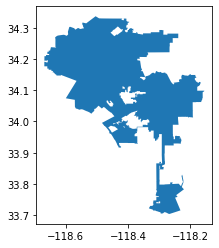

In [10]:
# Read city of Los Angeles boundary file
la = gpd.read_file('input/la_city_boundary/la_city_boundary_1570551157861.geojson')
la.plot()

In [11]:
sit_lie_all_gdf_clipped = cl.clip_shp(sit_lie_all_gdf, la)

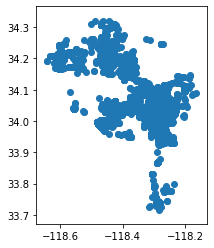

In [12]:
sit_lie_all_gdf_clipped.plot()

### Join arrests data to hexbin geodataframes

In [13]:
sit_lie_mile = gpd.sjoin(sit_lie_all_gdf, mile_gdf, op='contains', how="inner")
sit_lie_halfmile = gpd.sjoin(sit_lie_all_gdf, halfmileshp, op='contains', how="inner")

//anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [14]:
sit_lie_all_gdf

,report_id,arrest_date,time,area_id,area_name,reporting_district,age,sex_code,descent_code,charge_group_code,charge_group_description,arrest_type_code,charge,charge_description,address,cross_street,location,year,day,month,monthname,weekday,hour,minute,night,latitude,longitude,geometry
393,192116601,2019-10-02,0900,21,Topanga,2185,37,M,W,20,Disorderly Conduct,M,41.18(A)LAM,LOITER/OBSTRUCT STREET/SIDEWALK/ETC****,VENTURA BL,FARRALONE AV,"34.1687, -118.6102",2019,2,10,October,Wednesday,09,00,False,34.1687,-118.6102,POINT (-118.6102 34.1687)
490,190816446,2019-10-02,1725,8,West LA,882,43,F,W,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,SAWTELLE,TENNESSEE,"34.0367, -118.44",2019,2,10,October,Wednesday,17,25,False,34.0367,-118.4400,POINT (-118.44 34.0367)
568,192116563,2019-10-01,1145,21,Topanga,2156,23,M,B,24,Miscellaneous Other Violations,M,41.18LAMC,LOITERING (GENERALLY),VICTORY,CANOGA,"34.1878, -118.5975",2019,1,10,October,Tuesday,11,45,False,34.1878,-118.5975,POINT (-118.5975 34.1878)
572,191421356,2019-10-01,0955,14,Pacific,1431,49,M,W,nan,NaN,I,41.18(A)LAM,NaN,MILDRED AV,PACIFIC AV,"33.9867, -118.4708",2019,1,10,October,Tuesday,09,55,False,33.9867,-118.4708,POINT (-118.4708 33.9867)
711,192116565,2019-10-01,1145,21,Topanga,2156,52,F,W,24,Miscellaneous Other Violations,M,41.18LAMC,LOITERING (GENERALLY),VICTORY,CANOGA,"34.1878, -118.5975",2019,1,10,October,Tuesday,11,45,False,34.1878,-118.5975,POINT (-118.5975 34.1878)
751,192116564,2019-10-01,1145,21,Topanga,2156,28,M,W,24,Miscellaneous Other Violations,M,41.18LAMC,LOITERING (GENERALLY),VICTORY,CANOGA,"34.1878, -118.5975",2019,1,10,October,Tuesday,11,45,False,34.1878,-118.5975,POINT (-118.5975 34.1878)
794,191421261,2019-09-30,0850,14,Pacific,1431,32,M,W,nan,NaN,I,41.18(A)LAM,NaN,GRAND CANAL,ALBERTA,"33.988, -118.4703",2019,30,9,September,Monday,08,50,False,33.9880,-118.4703,POINT (-118.4703 33.988)
835,191421258,2019-09-30,0850,14,Pacific,1431,28,F,W,nan,NaN,I,41.18(A)LAM,NaN,THE GRAND CANAL,ALBERTA,"33.9867, -118.4693",2019,30,9,September,Monday,08,50,False,33.9867,-118.4693,POINT (-118.4693 33.9867)
902,191421260,2019-09-30,1530,14,Pacific,1431,34,F,W,nan,NaN,I,41.18(A)LAM,NaN,GRAND CANAL,CANAL ST,"33.988, -118.4703",2019,30,9,September,Monday,15,30,False,33.9880,-118.4703,POINT (-118.4703 33.988)
1021,190816326,2019-09-29,2020,8,West LA,854,50,M,W,20,Disorderly Conduct,M,41.18DLAMC,SIT/LIE/SLEEP SIDEWALK OR STREET,COTNER,NEBRASKA,"34.0437, -118.443",2019,29,9,September,Sunday,20,20,False,34.0437,-118.4430,POINT (-118.443 34.0437)
